# Image classification Training with Hub2.0: the Simpsons family

Author: Margaux Masson-Forsythe

## Imports

In [ ]:
# check GPU
!nvidia-smi

Wed Aug 18 20:18:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    66W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install hub==2.0.7

In [ ]:
import hub
import matplotlib.pyplot as plt
import glob 
import tensorflow as tf
tf.executing_eagerly()
import random
from PIL import Image
import os
from tqdm import tqdm
import numpy as np

In [ ]:
print(hub.__version__)
print(tf.__version__)

2.0.7
2.6.0


In [ ]:
import os
os.environ['BUGGER_OFF'] = 'true'

## Training

In [ ]:
ds_family_S = hub.load('hub://margauxmforsythe/the-family-simpsons-characters-dataset-resized-224x224')
print(len(ds_family_S))

Opening dataset in read-only mode as you don't have write permissions.
6361


0
(224, 224, 3)


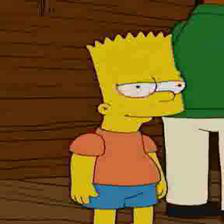

In [ ]:
# Check the dataset was correctly uploaded to Hub
print(ds_family_S.labels[0].numpy()[0])
print(ds_family_S.images[0].numpy().shape)
Image.fromarray(ds_family_S.images[0].numpy())

In [ ]:
numclasses = 5
batch_size = 8

def to_model_fit(item):
    x = item['images']/255 # normalize
    y = item['labels']
    # if you want to use categorical labels instead:
    # Change labels to categorical
    # label = tf.cast(item['labels'][0], tf.int32)
    # y = tf.one_hot(label, numclasses)
    return (x, y)

image_count = len(ds_family_S)
print(f"Images count: {image_count}")
ds_tf = ds_family_S.tensorflow()
ds_tf = ds_tf.map(lambda x: to_model_fit(x))

train_size = int(0.8 * image_count)
val_size = int(0.2 * image_count)
print(f"{train_size} training images and {val_size} validation images. Batch size of {batch_size}")

list_ds = ds_tf.shuffle(image_count)
val_ds = ds_tf.take(val_size)
train_ds = ds_tf.skip(val_size)

train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.shuffle(val_size)
val_ds = val_ds.batch(batch_size)


Images count: 6361
5088 training images and 1272 validation images. Batch size of 8


In [ ]:
# Load the pretained model
pretrained_mobileNetv2 = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), 
                                                include_top=False, 
                                                weights='imagenet')
pretrained_mobileNetv2.trainable = False

model = tf.keras.Sequential([
                            pretrained_mobileNetv2,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(numclasses, activation='softmax')
])

# Compile the model, we are using the Adam optimizer with 
# a learning rate of 0.001, the SparseCategoricalCrossentropy loss
# and SparseCategoricalAccuracy because our labels are 
# not categorical
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# If using categorical labels
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# Callback to top the training if val loss is not decreasing after 
# 5 epochs
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=5,
                                                      verbose=1,
                                                      restore_best_weights=True)

# Start training over 50 epoch
history = model.fit(train_ds, validation_data=val_ds, epochs = 50, 
          callbacks=[earlystop_callback])

Epoch 1/50
637/637 [==============================] - 75s 41ms/step - loss: 0.7029 - sparse_categorical_accuracy: 0.7510 - val_loss: 3.0053 - val_sparse_categorical_accuracy: 0.0582
Epoch 2/50
637/637 [==============================] - 39s 39ms/step - loss: 0.4600 - sparse_categorical_accuracy: 0.8353 - val_loss: 3.6778 - val_sparse_categorical_accuracy: 0.0731
Epoch 3/50
637/637 [==============================] - 39s 39ms/step - loss: 0.4052 - sparse_categorical_accuracy: 0.8562 - val_loss: 2.4689 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/50
637/637 [==============================] - 38s 39ms/step - loss: 0.3712 - sparse_categorical_accuracy: 0.8693 - val_loss: 2.5386 - val_sparse_categorical_accuracy: 0.2759
Epoch 5/50
637/637 [==============================] - 39s 39ms/step - loss: 0.3306 - sparse_categorical_accuracy: 0.8839 - val_loss: 2.1377 - val_sparse_categorical_accuracy: 0.3758
Epoch 6/50
637/637 [==============================] - 38s 38ms/step - loss: 0.3218 - spars

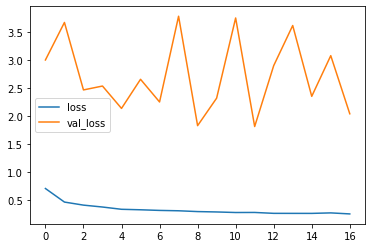

In [ ]:
import pandas as pd
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.show()

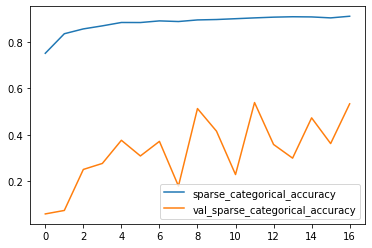

In [ ]:
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()
plt.show()

## Testing

In [ ]:
ds_test = hub.load('hub://margauxmforsythe/the-family-simpsons-characters-test-set-resized-224x224') # simpsons test set 
print(len(ds_test))

Opening dataset in read-only mode as you don't have write permissions.
200


In [ ]:
classes_family=['bart_simpson', 'marge_simpson', 'homer_simpson', 'maggie_simpson', 'lisa_simpson']

bart_simpson
0


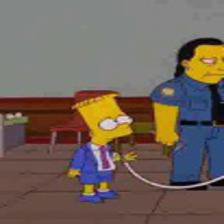

In [ ]:
print(classes_family[ds_test.labels[0].numpy()[0]])
print(ds_test.labels[0].numpy()[0])
Image.fromarray(ds_test.images[0].numpy())

In [ ]:
# Create a TF test dataset that we shuffle and batch with a batch size of the size of ds_test
ds_test_prediction = ds_test.tensorflow().batch(len(ds_test))
ds_tf = ds_test_prediction.map(lambda x: to_model_fit(x))

In [ ]:
# Predictions on the test set
predictions_test_ds = model.predict(ds_tf, verbose=1)

# Returns the indice of the highest predicted probability along the axis 1
y_pred = np.argmax(predictions_test_ds, axis=1)

# Gathers the labels from ds_test in a list
y_true = [label.numpy()[0] for label in ds_test.labels]

1/1 [==============================] - 7s 7s/step


In [ ]:
# Map the labels
y_pred_names = [classes_family[p] for p in y_pred]
y_true_names = [classes_family[p] for p in y_true]

In [ ]:
assert len(y_pred_names)==len(y_true_names)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 84.00%


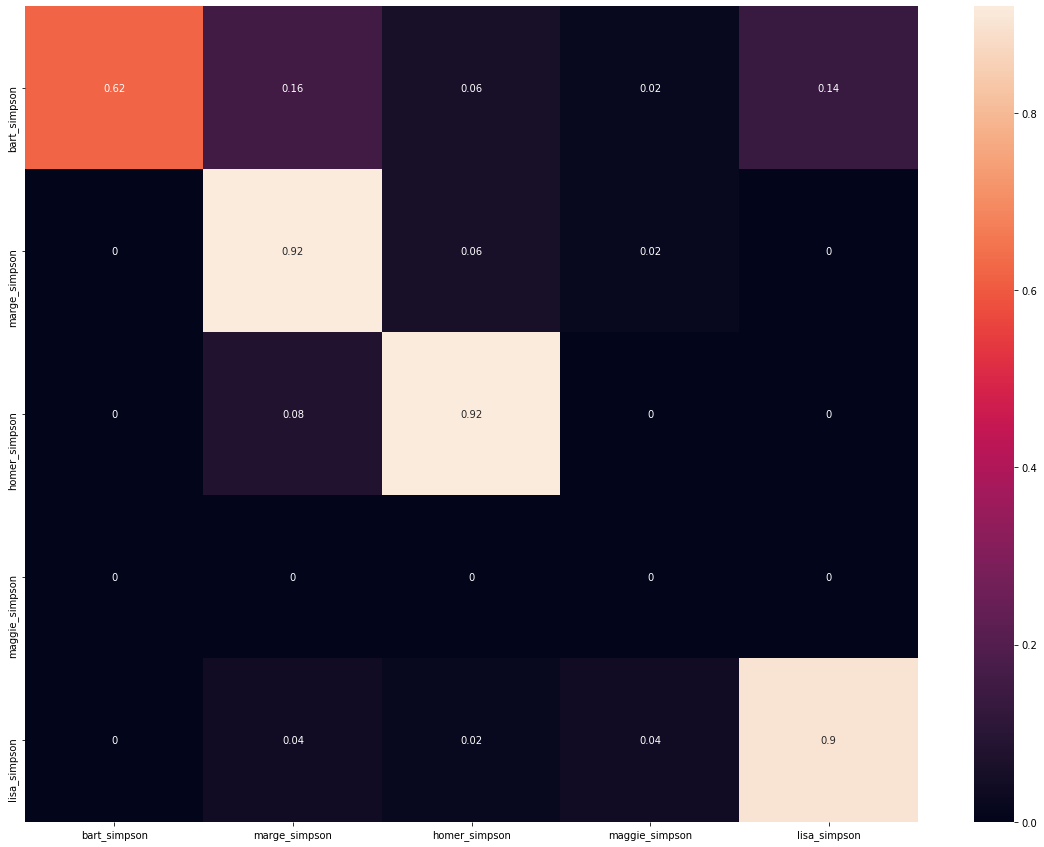

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_names, y_pred_names, normalize='true', labels=classes_family)
df_cm = pd.DataFrame(cm, index = classes_family, columns = classes_family)
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=True)

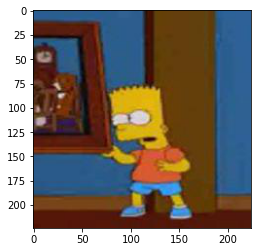

Predicted class: marge_simpson, real class: bart_simpson 




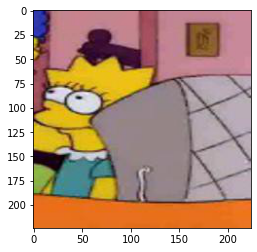

Predicted class: lisa_simpson, real class: lisa_simpson 




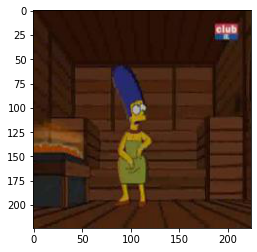

Predicted class: marge_simpson, real class: marge_simpson 




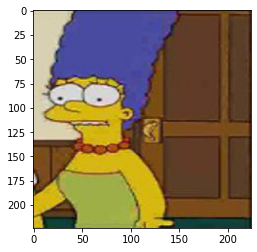

Predicted class: marge_simpson, real class: marge_simpson 




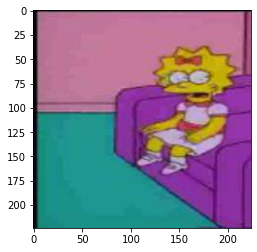

Predicted class: lisa_simpson, real class: lisa_simpson 




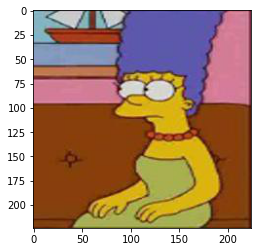

Predicted class: marge_simpson, real class: marge_simpson 




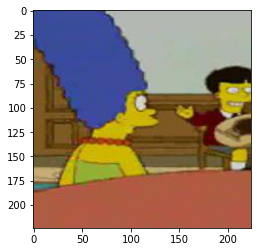

Predicted class: marge_simpson, real class: marge_simpson 




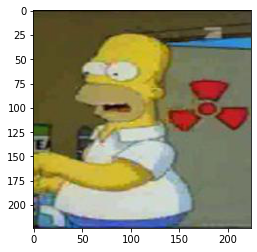

Predicted class: homer_simpson, real class: homer_simpson 




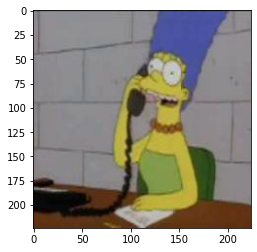

Predicted class: marge_simpson, real class: marge_simpson 




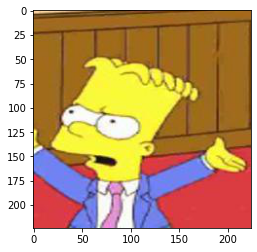

Predicted class: lisa_simpson, real class: bart_simpson 




In [ ]:
# Collect all images in test set in a list
images_test = ds_test[:].images.numpy()

# Choose how many test predictions to visualize 
number_images_to_show = 10
# Indexes of the images to show are random (to get more diverse representations of the predictions)
random_indexes_list = [random.randint(0,len(ds_test)) for i in range(number_images_to_show)]

# Go through the random indexes and show the image, real label and predicted label
for i in random_indexes_list:
  plt.imshow(images_test[i])
  plt.show()
  print(f"Predicted class: {y_pred_names[i]}, real class: {y_true_names[i]} \n\n")